Initial Data Loading and Cleaning

In [24]:
#libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

In [25]:
#define relative path to dataset
path_train = '/Users/sumaiyauddin/Documents/ML/Project/sign_mnist_train.csv'
path_test = '/Users/sumaiyauddin/Documents/ML/Project/sign_mnist_test.csv'

#define image resolution 
res = (28,28)

In [26]:
#saving data into pandas dataframes 
test = pd.read_csv(path_test)
train = pd.read_csv(path_train)

In [27]:
#printing shape
print(f'Train Shape:{train.shape}')
print(f'Test Shape:{test.shape}')


Train Shape:(27455, 785)
Test Shape:(7172, 785)


The training dataset consists of 27455 28x28 pixel grayscale images, including the associated label. The testing dataset consists of 7172 28x28 images. The label and pixels are split into X and y for both training and testing data.

In [28]:
#training data 
X_train = train.iloc[:,1:]
y_train = train.iloc[:,0]

#testing data
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

The below is a function to find the indices of a specified label.

In [29]:
#fuction to find the indices given a label 
def find_indices(data,label):
    #check if data is numpy array
    if type(data) == np.ndarray:
        #return indices
        return np.where(data==label)
    #check if data is pandas series 
    elif type(data) == pd.Series:
        #return indices
        return data[data==label].index
    #else not supported in this function
    else:
        raise Exception('Not supported data type for this function.')

Creating a dictionary where key is the numeric label in the dataset and value is the corresponding letter.

In [30]:
#letters
letters = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
#numbers 
numbers = sorted(list(y_train.unique()))
#dictionary of labels 
labels = dict(zip(numbers,letters))

In [31]:
#fuction to find the indices given a label 
def find_indices(data,label):
    #check if data is numpy array
    if type(data) == np.ndarray:
        #return indices
        return np.where(data==label)
    #check if data is pandas series 
    elif type(data) == pd.Series:
        #return indices
        return data[data==label].index
    #else not supported in this function
    else:
        raise Exception('Not supported data type for this function.')

In [32]:
#canny edge detection 
def canny_edge_detection(image,sigma):
    #check if numpy contents' data type is uint8, which is required for cv2.Canny 
    if image.dtype != 'uint8':
        #convert image dtype 
        image = np.uint8(image)
    #calculate lower and upper bounds for Canny function 
    md = np.median(image)
    lower = int(max(0,(1 - sigma) * md))
    upper = int(min(255, (1 + sigma) * md))
    #return edges detected 
    return cv2.Canny(image, lower, upper)

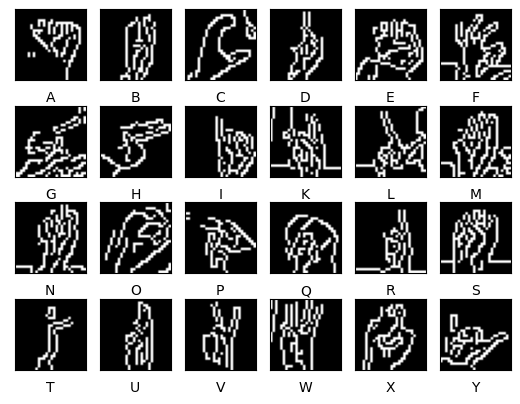

In [33]:
#visualization of dataset 
fix, ax = plt.subplots(4,6)
ax = ax.ravel()
pos = 0 

#loop through each label in dataset 
for label in range(0,26):
    #if label is not included in dataset 
    if label in [9,25]:
        continue
    #find first index of label
    idx = find_indices(y_train,label)[0]
    #display first found image 
    ax[pos].imshow(canny_edge_detection(X_train.iloc[idx,:].values.reshape(res),.25),cmap='gray')
    #set x label as dataset label
    ax[pos].set(xlabel=labels[label])
    #do not show ticks 
    ax[pos].set_xticks([])
    ax[pos].set_yticks([])
    #increment for subplotting 
    pos+=1

In [34]:
#function to convert dataframe of images to dataframe of edges 
def convert_img_to_edges(data):
    #list to store data
    edges_data = []
    #looping through dataframe rows 
    for index, row in data.iterrows():
        #reshaping image 
        img = row.values.reshape(res)
        #finding edges 
        edges = list(canny_edge_detection(img,.25).flatten())
        #appending to list 
        edges_data.append(edges)
    #return dataframe 
    return pd.DataFrame(edges_data, columns=data.columns)

In [35]:
#converting images to edges 
X_train_edges = convert_img_to_edges(X_train)
X_test_edges = convert_img_to_edges(X_test)

Doing normalization and standardization on edges data

In [36]:
#normalized data 
X_train_edg_nm = X_train_edges/255 
X_test_edg_nm = X_test_edges/255

#standardized data 
#using sklearn standard scaler model and fitting on training data 
sc_edg = StandardScaler().fit(X_train_edges)
X_train_edg_sc = sc_edg.transform(X_train_edges)
X_test_edg_sc = sc_edg.transform(X_test_edges)

#### Applying naive bayes on edges data

In [37]:
gnb = GaussianNB()

In [38]:
y_pred_edges = gnb.fit(X_train_edges, y_train).predict(X_test_edges)

In [39]:
print(f"Accuracy: {accuracy_score(y_test, y_pred_edges)}")
print("Classification report:")
print(classification_report(y_test, y_pred_edges, target_names=letters))


Accuracy: 0.24484104852203012
Classification report:
              precision    recall  f1-score   support

           A       0.52      0.04      0.07       331
           B       0.49      0.08      0.14       432
           C       0.79      0.29      0.42       310
           D       0.44      0.10      0.16       245
           E       0.16      0.91      0.27       498
           F       0.55      0.23      0.33       247
           G       0.36      0.55      0.43       348
           H       0.70      0.31      0.42       436
           I       0.22      0.16      0.18       288
           K       0.29      0.22      0.25       331
           L       0.22      0.12      0.16       209
           M       0.08      0.12      0.10       394
           N       0.09      0.29      0.14       291
           O       0.04      0.01      0.02       246
           P       0.74      0.53      0.62       347
           Q       0.21      0.12      0.15       164
           R       0.33     

In [40]:
# applying NB on normalized edges data
y_pred_edg_nm = gnb.fit(X_train_edg_nm, y_train).predict(X_test_edg_nm)

print(f"Accuracy: {accuracy_score(y_test, y_pred_edg_nm)}")
print("Classification report:")
print(classification_report(y_test, y_pred_edg_nm, target_names=letters))


Accuracy: 0.24484104852203012
Classification report:
              precision    recall  f1-score   support

           A       0.52      0.04      0.07       331
           B       0.49      0.08      0.14       432
           C       0.79      0.29      0.42       310
           D       0.44      0.10      0.16       245
           E       0.16      0.91      0.27       498
           F       0.55      0.23      0.33       247
           G       0.36      0.55      0.43       348
           H       0.70      0.31      0.42       436
           I       0.22      0.16      0.18       288
           K       0.29      0.22      0.25       331
           L       0.22      0.12      0.16       209
           M       0.08      0.12      0.10       394
           N       0.09      0.29      0.14       291
           O       0.04      0.01      0.02       246
           P       0.74      0.53      0.62       347
           Q       0.21      0.12      0.15       164
           R       0.33     

In [41]:
# applying NB on standardized edges data
y_pred_edg_sc = gnb.fit(X_train_edg_sc, y_train).predict(X_test_edg_sc)

print(f"Accuracy: {accuracy_score(y_test, y_pred_edg_sc)}")
print("Classification report:")
print(classification_report(y_test, y_pred_edg_sc, target_names=letters))


Accuracy: 0.2392638036809816
Classification report:
              precision    recall  f1-score   support

           A       0.48      0.04      0.07       331
           B       0.51      0.08      0.14       432
           C       0.80      0.29      0.42       310
           D       0.44      0.10      0.16       245
           E       0.16      0.91      0.27       498
           F       0.47      0.18      0.26       247
           G       0.37      0.56      0.44       348
           H       0.67      0.29      0.41       436
           I       0.19      0.16      0.17       288
           K       0.29      0.22      0.25       331
           L       0.13      0.06      0.08       209
           M       0.09      0.15      0.11       394
           N       0.09      0.29      0.14       291
           O       0.03      0.01      0.02       246
           P       0.74      0.53      0.62       347
           Q       0.21      0.12      0.15       164
           R       0.08      

we can see all of them are giving similar accuracy.

#### Applying NB on normalized and standardized 

In [42]:
#normalized data 
X_train_norm = X_train/255 
X_test_norm = X_test/255

#standardized data 
#using sklearn standard scaler model and fitting on training data 
sc = StandardScaler().fit(X_train)
X_train_sc = sc.transform(X_train)
X_test_sc = sc.transform(X_test)


In [46]:
# applying NB on normalized data
y_pred_nm = gnb.fit(X_train_norm, y_train).predict(X_test_norm)

print(f"Accuracy: {accuracy_score(y_test, y_pred_nm)}")
print("Classification report:")
print(classification_report(y_test, y_pred_nm, target_names=letters))


Accuracy: 0.3898494143892917
Classification report:
              precision    recall  f1-score   support

           A       0.71      0.48      0.57       331
           B       0.96      0.40      0.56       432
           C       0.72      0.50      0.59       310
           D       0.60      0.40      0.48       245
           E       0.53      0.56      0.55       498
           F       0.39      0.26      0.31       247
           G       0.54      0.56      0.55       348
           H       0.85      0.39      0.53       436
           I       0.22      0.45      0.30       288
           K       0.27      0.41      0.33       331
           L       0.41      0.45      0.43       209
           M       0.37      0.19      0.25       394
           N       0.38      0.31      0.34       291
           O       0.37      0.49      0.42       246
           P       0.43      0.81      0.56       347
           Q       0.29      0.60      0.39       164
           R       0.13      

In [45]:
# applying NB on standerdized data
y_pred_sc = gnb.fit(X_train_sc, y_train).predict(X_test_sc)

print(f"Accuracy: {accuracy_score(y_test, y_pred_sc)}")
print("Classification report:")
print(classification_report(y_test, y_pred_sc, target_names=letters))


Accuracy: 0.3898494143892917
Classification report:
              precision    recall  f1-score   support

           A       0.71      0.48      0.57       331
           B       0.96      0.40      0.56       432
           C       0.72      0.50      0.59       310
           D       0.60      0.40      0.48       245
           E       0.53      0.56      0.55       498
           F       0.39      0.26      0.31       247
           G       0.54      0.56      0.55       348
           H       0.85      0.39      0.53       436
           I       0.22      0.45      0.30       288
           K       0.27      0.41      0.33       331
           L       0.41      0.45      0.43       209
           M       0.37      0.19      0.25       394
           N       0.38      0.31      0.34       291
           O       0.37      0.49      0.42       246
           P       0.43      0.81      0.56       347
           Q       0.29      0.60      0.39       164
           R       0.13      

### Logistic regrassion on normalized data

In [51]:
lr = LogisticRegression(max_iter=5000)

In [52]:
# applying logistic regression on normalized data
y_pred_lr_nm = lr.fit(X_train_norm, y_train).predict(X_test_norm)

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_nm)}")
print("Classification report:")
print(classification_report(y_test, y_pred_lr_nm, target_names=letters))


Accuracy: 0.6919966536530954
Classification report:
              precision    recall  f1-score   support

           A       0.86      1.00      0.92       331
           B       1.00      0.91      0.95       432
           C       0.87      0.93      0.90       310
           D       0.90      0.86      0.88       245
           E       0.88      0.88      0.88       498
           F       0.72      0.91      0.80       247
           G       0.83      0.73      0.78       348
           H       0.81      0.71      0.75       436
           I       0.56      0.59      0.57       288
           K       0.67      0.41      0.51       331
           L       0.65      0.89      0.75       209
           M       0.70      0.62      0.66       394
           N       0.67      0.57      0.62       291
           O       0.99      0.63      0.77       246
           P       0.93      0.94      0.94       347
           Q       0.61      0.74      0.67       164
           R       0.16      

In [53]:
# applying Logistic regression on standerdized data
y_pred_lr_sc = lr.fit(X_train_sc, y_train).predict(X_test_sc)

print(f"Accuracy: {accuracy_score(y_test, y_pred_lr_sc)}")
print("Classification report:")
print(classification_report(y_test, y_pred_lr_sc, target_names=letters))


Accuracy: 0.6985499163413273
Classification report:
              precision    recall  f1-score   support

           A       0.84      1.00      0.91       331
           B       1.00      0.89      0.94       432
           C       0.91      0.90      0.91       310
           D       0.92      0.92      0.92       245
           E       0.92      0.87      0.89       498
           F       0.69      0.91      0.78       247
           G       0.82      0.78      0.80       348
           H       0.78      0.66      0.72       436
           I       0.65      0.66      0.66       288
           K       0.61      0.40      0.48       331
           L       0.53      0.84      0.65       209
           M       0.75      0.71      0.73       394
           N       0.64      0.57      0.60       291
           O       1.00      0.65      0.79       246
           P       0.87      0.95      0.91       347
           Q       0.62      0.74      0.68       164
           R       0.17      